# Importing Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import squarify
# import textwrap
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import panel as pn
pn.extension('tabulator')
import hvplot.pandas
import holoviews as hv

from holoviews import opts
hv.extension('bokeh')
import matplotlib as mpl
from panel.interact import interact
import bokeh
 
import bokeh.palettes


import streamlit as st

# Pre-processing:
## 1. Check for column names and Fix Errors
## 2. Remove $ sign and '-' from all columns where they are present
## 3. Change datatype from objects to int after the above two.
## 4. Removing " , " (comma) from all numerical numbers.

### Check File Contents


In [4]:
df = pd.read_csv('Financials.csv')

# Display the first few rows of the DataFrame
df.head()

,Segment,Country,Product,Discount Band,Units Sold,Manufacturing Price,Sale Price,Gross Sales,Discounts,Sales,COGS,Profit,Date,Month Number,Month Name,Year
0,Government,Canada,Carretera,None,"$1,618.50",$3.00,$20.00,"$32,370.00",$-,"$32,370.00","$16,185.00","$16,185.00",01/01/2014,1,January,2014
1,Government,Germany,Carretera,None,"$1,321.00",$3.00,$20.00,"$26,420.00",$-,"$26,420.00","$13,210.00","$13,210.00",01/01/2014,1,January,2014
2,Midmarket,France,Carretera,None,"$2,178.00",$3.00,$15.00,"$32,670.00",$-,"$32,670.00","$21,780.00","$10,890.00",01/06/2014,6,June,2014
3,Midmarket,Germany,Carretera,None,$888.00,$3.00,$15.00,"$13,320.00",$-,"$13,320.00","$8,880.00","$4,440.00",01/06/2014,6,June,2014
4,Midmarket,Mexico,Carretera,None,"$2,470.00",$3.00,$15.00,"$37,050.00",$-,"$37,050.00","$24,700.00","$12,350.00",01/06/2014,6,June,2014


### Trim All White spaces in object columns in the dataset

In [5]:
# Select columns of object and string data types from the DataFrame 'df'
df_obj = df.select_dtypes(['object', 'string'])

# Apply the strip method to all elements in the selected columns to remove leading and trailing whitespaces
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

# Remove leading and trailing whitespaces from column names
df.columns = df.columns.str.strip()

# Display the column names
df.columns


Index(['Segment', 'Country', 'Product', 'Discount Band', 'Units Sold',
       'Manufacturing Price', 'Sale Price', 'Gross Sales', 'Discounts',
       'Sales', 'COGS', 'Profit', 'Date', 'Month Number', 'Month Name',
       'Year'],
      dtype='object')

### Create variables for Column Names

In [6]:
[
 Segment, Country, Product,
 Discount_Band, Units_Sold,
 Manufacturing_Price, Sale_Price,
 Gross_Sales, Discounts,
 Sales, COGS, Profit, Date,
 Month_Number, Month_Name,
 Year
] = [
'Segment', 'Country', 'Product',
 'Discount Band', 'Units Sold',
 'Manufacturing Price', 'Sale Price',
 'Gross Sales', 'Discounts',
 'Sales', 'COGS', 'Profit', 'Date',
 'Month Number', 'Month Name', 'Year'] 


### Seperate Columns to Facts (i.e Categorical) and Numerical Columns

In [7]:
Numerical_Columns = [Units_Sold, Manufacturing_Price, Sale_Price, Gross_Sales, Discounts, Sales, COGS, Profit]

Fact_Columns = [Segment, Country, Product, Discount_Band]

Varying_Numerical_Columns =  [Gross_Sales, Discounts, Sales, COGS, Profit]

### Remove all special characters in Numerical Columns

In [8]:

df[Numerical_Columns] = df[Numerical_Columns].replace({'\$':'','-':'0',',':''},regex=True)

### Numbers in () are Negative, therefore Preppend '-'  to the values in brackets

In [9]:
df[Numerical_Columns] = df[Numerical_Columns].replace({'\(':'-','\)':'',' ':''},regex=True)
 

### Convert Numerical columns to Float data type and Units Sold to Integer whole number

In [10]:
df[Numerical_Columns] = df[Numerical_Columns].astype(float)
df[Units_Sold] = df[Units_Sold].astype(int)
 

## Convert date to datetime 

In [11]:
df[Date] = pd.to_datetime(df[Date])

## Delete Non essential columns

In [12]:
Non_Essential_columns = [Month_Number, Month_Name, Year]
df = df.drop(Non_Essential_columns, axis=1)

## Getting Unique Items in DataFrame

In [19]:
def get_unique_items_list_in_column(column_name):
    """
    Returns a list of unique items in the specified column of a DataFrame 'df'.
    
    Parameters:
    column_name: The name of the column to retrieve unique items from.
    
    Returns:
    full_list: A list of unique items in the specified column. The list is sorted if the column name is not 'Discount_Band' or 'Date'. If the column name is 'Date', the list contains unique years.
    """
  
    # Check if the column name is not 'Discount_Band'
    if column_name != Discount_Band:
        # Get a list of unique items in the specified column and sort it
        full_list = df[column_name].unique().tolist()
        full_list = sorted(full_list)
    
    else:
        # Get a list of unique items in the specified column
        full_list = df[column_name].unique().tolist()
    
    # Check if the column name is 'Date'
    if column_name == Date:
        # Get a list of unique years in the specified column and sort it
        full_list = df[column_name].dt.year.unique().tolist()
        full_list = sorted(full_list)
          
    return full_list
get_unique_items_list_in_column(Discount_Band)

['None', 'Low', 'Medium', 'High']

#  Pipelines for First Chart

In [14]:
def create_bar_chart(x_axis=Segment, y_axis=Sales):
    """
    Creates a bar chart using hvplot.
    
    Parameters:
    x_axis: The column name to use as the x-axis. Default is 'Segment'.
    y_axis: The column name to use as the y-axis. Default is 'Sales'.
    
    Returns:
    bar_chart: A horizontal bar chart created using hvplot.
    """
    
    # Create a copy of the dataframe
    bar_df = df
    
    # If the x-axis is 'Discount_Band', set the categories and order
    if x_axis == Discount_Band:
        bar_df[x_axis] = pd.Categorical(bar_df[x_axis],
                                        categories=get_unique_items_list_in_column(Discount_Band), ordered=True)
        
    # Group the dataframe by the x-axis and sum the numerical columns
    bar_df = bar_df.groupby(x_axis)[Numerical_Columns].sum().reset_index().reset_index(drop=True)
        
    # Select only the x-axis and y-axis columns
    bar_df = bar_df[[x_axis]+ Numerical_Columns]
    
    # Select only the x-axis and y-axis columns
    bar_df = bar_df[[x_axis,y_axis]]
    
    # Create a horizontal bar chart using hvplot
    bar_chart = bar_df.hvplot(x=x_axis, y=y_axis, kind='bar',
                              xlabel=x_axis.capitalize(), ylabel=y_axis.capitalize(),
                              title=f'{y_axis.capitalize()} per {x_axis.capitalize()}',
                              yformatter='%.0f',
                              width=550,
                              height=400,
                              )
    return bar_chart


In [15]:
create_bar_chart( x_axis=Segment, y_axis=Sales)

:Bars   [Segment]   (Sales)

In [16]:
def create_Products_stacked_bar_chart(x_axis=Segment, 
                                      y_axis= Sales,
                                      product_List=get_unique_items_list_in_column(Product)):
    """
    Creates a stacked bar chart using hvplot.
    
    Parameters:
    x_axis: The column name to use as the x-axis. Default is 'Segment'.
    y_axis: The column name to use as the y-axis. Default is 'Sales'.
    product_List: A list of products to include in the chart. Default is the list of unique products in the 'Product' column.
    
    Returns:
    stacked_bar_chart: A stacked bar chart created using hvplot, or a message if the x-axis is 'Product'.
    """
    
    # Define a list of complementary colors to use for the chart
    complementary_colors = ["#ba2649", "#ffa7ca", "#1a6b54", "#f7d560", "#5c3c92", "#f2a0a1"]
    
    # Check if the x-axis is not 'Product'
    if x_axis != Product:
            
            # Create a copy of the dataframe
            Products_df = df

            # Group the dataframe by x-axis and product and sum the y-axis values
            Products_df = Products_df.groupby([x_axis, Product])[y_axis].sum().reset_index().reset_index(drop=True)


            # Filter the data to include only products in product_List
            Products_df_filtered = Products_df[Products_df[Product].isin(product_List)]

            # Pivot the data to create a stacked bar chart
            Products_df_pivot = Products_df_filtered.pivot(index=x_axis, 
                                                           columns=Product,
                                                           values=y_axis).fillna(0)


            # Create stacked bar chart using hvplot
            stacked_bar_chart =  Products_df_pivot.hvplot(stacked=True, kind='bar',
                                                          grid=True,
                                                          # Add labels and title
                                                          xlabel=x_axis.capitalize(),
                                                          ylabel=y_axis.capitalize(),
                                                          
                                                          yformatter='%.0f',
                                                          width=550,
                                                          height=400,
                                                          legend='top',
                                                         
                                                                                                    
                                                          color=complementary_colors, # Use the defined colors for each product
                                                          title=(f'{y_axis} per Product in each {x_axis}'),
                                                                                                                  
                                                                )
                                                         
    else: 
        # Return a message if the x-axis is 'Product'
        stacked_bar_chart = f'Product infograph for {y_axis} already available.<br>Please select another section in the <b>For Each </b> drop down menu'
                                                  
    return stacked_bar_chart
 

## Create Widgets For first chart

In [18]:
# Set the category to 'Product'
category = Product

# Get a list of unique items in the 'Product' column
labels = get_unique_items_list_in_column(category)


# First panel frame

# Create a Select widget for choosing the numerical column to use as the y-axis
bar_numeric_axis_widget = pn.widgets.Select(name='Total Amount of', options=Numerical_Columns, width=200)
# Create a Select widget for choosing the fact column to use as the x-axis
bar_fact_axis_widget = pn.widgets.Select(name='For Each', options= Fact_Columns, width=200)




# Second panel frame

# Create a CheckButtonGroup widget for selecting products to include in the chart
bar_product_checkbox_button_group = pn.widgets.CheckButtonGroup(options=labels, value=labels)
# Create a StaticText widget for displaying instructions
select_product_text = pn.widgets.StaticText(value=f'<b>Please Select / Unselect the {category} to view</b>')



# Bind the create_bar_chart function to the Select widgets
bound_first_plot = pn.bind(create_bar_chart,
                           x_axis= bar_fact_axis_widget,
                           y_axis= bar_numeric_axis_widget
                          )

# Bind the create_Products_stacked_bar_chart function to the Select and CheckButtonGroup widgets
bound_second_plot = pn.bind(create_Products_stacked_bar_chart,
                            x_axis= bar_fact_axis_widget,
                            y_axis= bar_numeric_axis_widget,
                            product_List= bar_product_checkbox_button_group
                           )

# Create a Row layout with two Columns
first_app = pn.Row(
    # First Column
    pn.Column(
        # Row with Select widgets
        pn.Row(
            bar_numeric_axis_widget,
            bar_fact_axis_widget),
        # Row with bound plot
        pn.Row(
            bound_first_plot, )
    ),
    # Spacer between Columns
    pn.layout.HSpacer(width=50),
    # Second Column
    pn.Column(
        select_product_text,
        bar_product_checkbox_button_group,
        bound_second_plot
    , ), sizing_mode='scale_both'
)
first_app

Row(sizing_mode='scale_both')
    [0] Column
        [0] Row
            [0] Select(name='Total Amount of', options=['Units Sold', ...], value='Units Sold', width=200)
            [1] Select(name='For Each', options=['Segment', 'Country', ...], value='Segment', width=200)
        [1] Row
            [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [1] HSpacer(width=50)
    [2] Column
        [0] StaticText(value='<b>Please Select /...)
        [1] CheckButtonGroup(options=['Amarilla', 'Carretera', ...], value=['Amarilla', 'Carretera', ...])
        [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

#  Pipelines for Second Chart

In [33]:
def create_bump_chart(y_axis=Sales, categorical_label=Segment,
                      year_considered=[min(df[Date].dt.year)],
                      categorical_label_list= get_unique_items_list_in_column(Segment)):
    """
    Creates a bump chart using hvplot.
    
    Parameters:
    y_axis: The column name to use as the y-axis. Default is 'Profit'.
    categorical_label: The column name to use as the categorical label. Default is 'Segment'.
    year_considered: A list of years to include in the chart. Default is the minimum year in the 'Date' column.
    categorical_label_list: A list of categorical labels to include in the chart. Default is the list of unique items in the 'Segment' column.
    
    Returns:
    bump_chart: A bump chart created using hvplot, or a message if no years or categorical labels are selected.
    """
    
    # Convert the year_considered list to a string
    year_list_str = ', '.join(map(str, year_considered))

    # Check if year_considered and categorical_label_list are not empty
    if year_considered != [] and categorical_label_list != []:
        # Create a copy of the dataframe
        bump_df = df 

        # Set the index to the 'Date' column
        bump_df = bump_df.set_index(Date)

        # Sort the dataframe by date
        bump_df = bump_df.sort_values(by=Date)

        # Group the dataframe by date and categorical label and sum the y-axis values
        bump_df = bump_df.groupby([Date, categorical_label])[y_axis].sum().reset_index().reset_index(drop=True)

        # Filter the data to include only items in categorical_label_list
        bump_df_filtered = bump_df[bump_df[categorical_label].isin(categorical_label_list)]

        # Filter the data to include only years in year_considered
        bump_df_filtered = bump_df_filtered[bump_df_filtered[Date].dt.year.isin(year_considered)].reset_index(drop=True)

        # Pivot the data to create a bump chart
        bump_df_pivot = bump_df_filtered.pivot(index=Date, 
                                               columns=categorical_label,
                                               values=y_axis).fillna(0)
        
        # Set the y-axis limits
        ylimits = ((),                   
                  (bump_df_pivot.stack().max() + (0.1 * bump_df_pivot.stack().max())))
        
        # Create a line chart using hvPlot
        bump_line_chart = bump_df_pivot.hvplot(x=Date, y=categorical_label_list,
                                               kind='line', grid=True,
                                               height=400, width=600,
                                               xlabel=Date, ylabel=y_axis,
                                               title=(f'Daily {y_axis} per {categorical_label} for year {year_list_str}'),
                                               legend='bottom',  
                                               yformatter='%.0f',
                                               
                                               ylim=(ylimits)
                                              )

        # Create a scatter chart using hvPlot with dots on each line
        bump_scatter_chart = bump_df_pivot.hvplot(x=Date, y=categorical_label_list,
                                                  kind='scatter', grid=True,
                                                  marker='o', legend='bottom',
                                                  width=550, height=400,
                                                  size=100)

        # Combine the line and scatter charts
        bump_chart = bump_line_chart * bump_scatter_chart
        
    elif year_considered == []:
        # Return a message if no years are selected
        bump_chart = f'<b>Please select the year to view.</b>'
    elif categorical_label_list == []:
        # Return a message if no categorical labels are selected
        bump_chart = f'<b>Please select the sub-category of {categorical_label} to view.</b>'
    
    return bump_chart


create_bump_chart()

:Overlay
   .NdOverlay.I  :NdOverlay   [Segment]
      :Curve   [Date]   (value)
   .NdOverlay.II :NdOverlay   [Segment]
      :Scatter   [Date]   (value)

## Create Widgets For second chart

## correct widget

In [ ]:
# Create a CheckButtonGroup widget for selecting years to include in the chart
checkbox_year_group = pn.widgets.CheckButtonGroup(options=get_unique_items_list_in_column(Date), value=[min(df['Date'].dt.year)])

# Create a Select widget for choosing the fact column to use as the categorical label
second_chart_fact_axis_widget = pn.widgets.Select(name='Select', options=Fact_Columns, width=200)  

# Create a CheckButtonGroup widget for selecting categorical labels to include in the chart
checkbutton_fact_subcategory_widget = pn.widgets.CheckButtonGroup(name='CheckButtonGroup', 
                                                 value=get_unique_items_list_in_column(second_chart_fact_axis_widget.value),
                                                 options=get_unique_items_list_in_column(second_chart_fact_axis_widget.value)
                                                                 )

# Create a Select widget for choosing the numerical column to use as the y-axis
second_chart_numeric_axis_widget = pn.widgets.Select(name='Total Amount of', options=Numerical_Columns, width=200)

# Define a callback function to update the options of the CheckButtonGroup widget
def update_checkbutton(event):
    checkbutton_options = get_unique_items_list_in_column(event.new)             
    checkbutton_fact_subcategory_widget.options = checkbutton_options

# Add the callback function to the Select widget
second_chart_fact_axis_widget.param.watch(update_checkbutton, 'value')

# Bind the create_bump_chart function to the widgets
bound_third_plot = pn.bind(
    create_bump_chart,
    year_considered=checkbox_year_group,
    categorical_label=second_chart_fact_axis_widget,
    y_axis=second_chart_numeric_axis_widget, 
    categorical_label_list=checkbutton_fact_subcategory_widget
    
)
 

# Create a Column layout with widgets and bound plot
second_app = pn.Column(second_chart_fact_axis_widget, checkbutton_fact_subcategory_widget, second_chart_numeric_axis_widget, checkbox_year_group, bound_third_plot)
 


# Third Chart

In [ ]:
def scatter_chart(x_axis=Gross_Sales,
                  y_axis=Units_Sold,
                  fact_category=Segment,
                  fact_subcategory=get_unique_items_list_in_column(Segment)):
    """
    Creates a scatter chart using hvplot.
    
    Parameters:
    x_axis: The column name to use as the x-axis. Default is 'Gross_Sales'.
    y_axis: The column name to use as the y-axis. Default is 'Units_Sold'.
    fact_category: The column name to use as the fact category. Default is 'Segment'.
    fact_subcategory: A list of fact subcategories to include in the chart. Default is the list of unique items in the 'Segment' column.
    
    Returns:
    scatter_chart: A scatter chart created using hvplot, or a message if no fact subcategories are selected or if x_axis and y_axis are the same.
    """
    
    # Check if fact_subcategory is empty
    if fact_subcategory == []:
        # Return a message if no fact subcategories are selected
        scatter_chart = f'<b>Please select the sub-category of {fact_category} to view.</b>'
    
    # Check if x_axis and y_axis are different
    elif x_axis != y_axis:
        # Create a copy of the dataframe
        scatter_df = df

        # Filter the data frame to only include the segments you want to view
        category_to_view = fact_subcategory
        scatter_df_filtered = scatter_df[scatter_df[fact_category].isin(category_to_view)]

        # Create a scatter chart using hvplot
        scatter_chart = scatter_df_filtered.hvplot.scatter(x=x_axis, y=y_axis, by=fact_category, 
                                                           xlabel=x_axis, ylabel=y_axis, 
                                                           title=f'{x_axis} vs {y_axis} by {fact_category}',
                                                           width=600, height=400,
                                                           yformatter='%.0f',
                                                           xformatter='%.0f',
                                                           legend='bottom',
                                                           rot=45)
        
    else:
        # Return a message if x_axis and y_axis are the same
        scatter_chart = f'<b>Please select two different columns to view.</b>'

    return scatter_chart


In [ ]:
# Create a Select widget for choosing the numerical column to use as the x-axis
third_chart_x_axis_widget = pn.widgets.Select(name='Select X-Axis', value= Varying_Numerical_Columns[0] , options=Varying_Numerical_Columns, width=200)  

# Create a Select widget for choosing the numerical column to use as the y-axis
third_chart_y_axis_widget = pn.widgets.Select(name='Select Y-Axis',  value= Varying_Numerical_Columns[1] , options=Varying_Numerical_Columns, width=200, )                                                         

# Create a Select widget for choosing the fact column to use as the fact category
scatter_fact_widget = pn.widgets.Select(name='Select Category', value= Fact_Columns[1] ,  options=Fact_Columns, width=200)

# Create a CheckButtonGroup widget for selecting fact subcategories to include in the chart
scatter_fact_subcategory_checkbutton_widget = pn.widgets.CheckButtonGroup(name='CheckButtonGroup', 
                                                 value = get_unique_items_list_in_column(scatter_fact_widget.value) ,
                                                 options = get_unique_items_list_in_column(scatter_fact_widget.value)
                                                                         )

# Define a callback function to update the options of the CheckButtonGroup widget
def update_checkbutton(event):
    checkbutton_options = get_unique_items_list_in_column(event.new)             
    scatter_fact_subcategory_checkbutton_widget.options = checkbutton_options

# Add the callback function to the Select widget
scatter_fact_widget.param.watch(update_checkbutton, 'value')

# Bind the scatter_chart function to the widgets
bound_scatter_plot = pn.bind(
    scatter_chart,  
    x_axis=third_chart_x_axis_widget,
    y_axis=third_chart_y_axis_widget,
    fact_category=scatter_fact_widget,
    fact_subcategory=scatter_fact_subcategory_checkbutton_widget 
)

# Create a Column layout with widgets and bound plot
third_app = pn.Column(third_chart_x_axis_widget,
                      third_chart_y_axis_widget,
                      scatter_fact_widget,
                      scatter_fact_subcategory_checkbutton_widget,
                      bound_scatter_plot)
 


In [ ]:
# Create a Column layout with three Rows
app = pn.Column( 
    # First Row with two Columns
   pn.Row(
    # First Column
    pn.Column(
        # Row with Select widgets
        pn.Row(
            bar_numeric_axis_widget,
            bar_fact_axis_widget),
        # Row with bound plot
        pn.Row(
            bound_first_plot, )
    ),
    # Spacer between Columns
    pn.layout.HSpacer(width=50),
    # Second Column
    pn.Column(
        select_product_text,
        bar_product_checkbox_button_group,
        bound_second_plot
    , ), sizing_mode='scale_both'
),
     
    # Second Row with a Column
    pn.Column(
        pn.layout.HSpacer(height=50),
        # Row with Select widgets
        pn.Row(second_chart_fact_axis_widget, second_chart_numeric_axis_widget),
        checkbutton_fact_subcategory_widget,
        checkbox_year_group,
        bound_third_plot
         
        
    ),      
    
    
       
    # Third Row with a Column
    pn.Column(
         pn.layout.HSpacer(height=50),
        # Row with Select widgets
        pn.Row( third_chart_y_axis_widget, third_chart_x_axis_widget),
        scatter_fact_widget,
        scatter_fact_subcategory_checkbutton_widget,
        bound_scatter_plot
        
        
    )
)

app.servable()


In [ ]:
df2= pd.DataFrame({'sales': np.random.randint(40,100,10),
                   'profit': np.random.randint(0,50,10),
                   'segment': np.random.choice(['A','B','C'],10)
                  })




x= df2['sales']
y= df2['profit']

unique_elements= df2['segment'].unique()
complimentary_colors = ["#ba2649", "#ffa7ca", "#1a6b54", "#f7d560", "#5c3c92", "#f2a0a1", 'black', 'red', 'indigo']   


# colors= {'A':"red", 'B':"blue", 'C':"yellow" }#, "#5c3c92", "#f2a0a1"]  

colors = dict(zip(unique_elements, complimentary_colors))

scatter_colour = [colors[c] for c in df2['segment'] ]

plt.scatter(x,y, color=scatter_colour)
plt.show()

# df2['segment'].nunique()

In [69]:
 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import textwrap
 
def create_bump_chartA(y_axis, categorical_label, year_considered, categorical_label_list):

    """
    Creates a bump chart using matplotlib.
    
    Parameters:
    y_axis: The column name to use as the y-axis.
    categorical_label: The column name to use as the categorical label.
    year_considered: A list of years to include in the chart.
    categorical_label_list: A list of categorical labels to include in the chart.
    
    Returns:
    None
    """
    
    # Convert the year_considered list to a string
    year_list_str = ', '.join(map(str, year_considered))

    # Check if year_considered and categorical_label_list are not empty
    if year_considered != [] and categorical_label_list != []:
        # Create a copy of the dataframe
        bump_df = df 

        # Set the index to the 'Date' column
        bump_df = bump_df.set_index(Date)

        # Sort the dataframe by date
        bump_df = bump_df.sort_values(by=Date)

        # Group the dataframe by date and categorical label and sum the y-axis values
        bump_df = bump_df.groupby([Date, categorical_label])[y_axis].sum().reset_index().reset_index(drop=True)

        # Filter the data to include only items in categorical_label_list
        bump_df_filtered = bump_df[bump_df[categorical_label].isin(categorical_label_list)]

        # Filter the data to include only years in year_considered
        bump_df_filtered = bump_df_filtered[bump_df_filtered[Date].dt.year.isin(year_considered)].reset_index(drop=True)

        # Pivot the data to create a bump chart
        bump_df_pivot = bump_df_filtered.pivot(index=Date, 
                                               columns=categorical_label,
                                               values=y_axis).fillna(0)
        # Format the dates to only include the month and day
        bump_df_pivot.index = bump_df_pivot.index.strftime('%d-%m %Y')

        
        # Create a line chart using matplotlib
        fig, ax = plt.subplots()
        for column in bump_df_pivot.columns:
            ax.plot(bump_df_pivot.index, bump_df_pivot[column], label=column)
            ax.scatter(bump_df_pivot.index, bump_df_pivot[column])
        
        # Wrap the x-axis tick labels
        tick_labels = [textwrap.fill(label, 5) for label in bump_df_pivot.index]
        ax.set_xticks(bump_df_pivot.index)
        ax.set_xticklabels(tick_labels, fontsize=7)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.legend()
        
        # st.pyplot(fig)
        plt.show()
        
    elif year_considered == []:
        # Display a message if no years are selected
        st.write('Please select the year to view.')
    elif categorical_label_list == []:
        # Display a message if no categorical labels are selected
        st.write('Please select at least one category.')


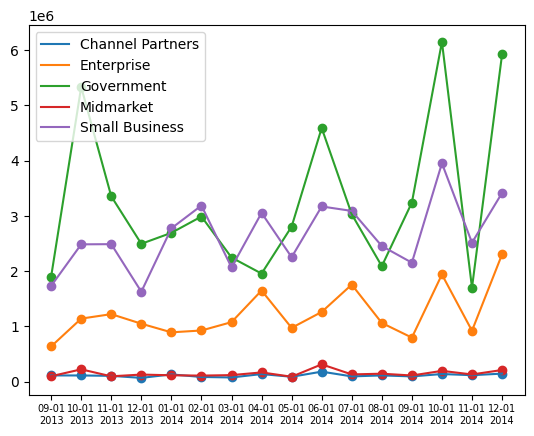

In [70]:
create_bump_chartA(Sales, categorical_label=Segment,
                      year_considered=[2013, 2014],
                      categorical_label_list= get_unique_items_list_in_column(Segment))

In [23]:

bump_chart_x_widget, bump_chart_y_widget = st.columns(2)
 
    
    
# Create widgets to select the x-axis and y-axis columns
bump_x_axis = bump_chart_x_widget.selectbox('Select X axis', Fact_Columns)
bump_y_axis = bump_chart_y_widget.selectbox('Select y axis :', Numerical_Columns)



categorical_label_list= st.multiselect('Select Subcategory to view',  get_unique_items_list_in_column(bump_x_axis),
                                  default= get_unique_items_list_in_column(bump_x_axis))

year_considered = st.multiselect('Select Category :', get_unique_items_list_in_column(Date), default = [min(df['Date'].dt.year)])

        

create_bump_chartA(bump_x_axis, bump_y_axis, year_considered , categorical_label_list)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
